In [48]:
# ARIMA, SARIMAX를 사용하여 SOL 예측

import pandas as pd
import os

def date_range(start, end):
    start = datetime.strptime(start, "%Y%m%d")
    end = datetime.strptime(end, "%Y%m%d")
    dates = [date.strftime("%Y%m%d") for date in pd.date_range(start, periods=(end-start).days+1)]
    return dates


path = "./forecasting_data/"
folder = os.listdir(path)

start_day = '2021-10-01'
end_day = '2022-06-30'

df = pd.DataFrame(index = pd.date_range(start=start_day, end=end_day,freq='1D'), columns = ["SOH"])

for f in folder: # 하루씩 데이터 가져옴
    month = f"{f[:4]}-{f[4:6]}-{f[6:]}"
    if pd.to_datetime(month) in df.index:
        try:
            rack = pd.read_feather(path + f + "/rack.feather")
            rack = rack[rack["RACK_ID"] == 2]

            t = pd.to_datetime(f"{f[:4]}-{f[4:6]}-{f[6:]}")
            df.loc[t]["SOH"] = rack.iloc[-1]["RACK_SOH"] # 하루 중 마지막 시간의 SOH만 저장
        except:
            continue

df["SOH"] = (df["SOH"]-80) * 5 # SOH(100% ~ 80%) to SOL(100% ~ 0%)
df.fillna(method='ffill', inplace = True) # 뒷 행을 기준으로 nan 채우기

#df.to_csv("day-to-soh.csv")

c:\users\juhyeong\desktop\rack_analysis\.venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


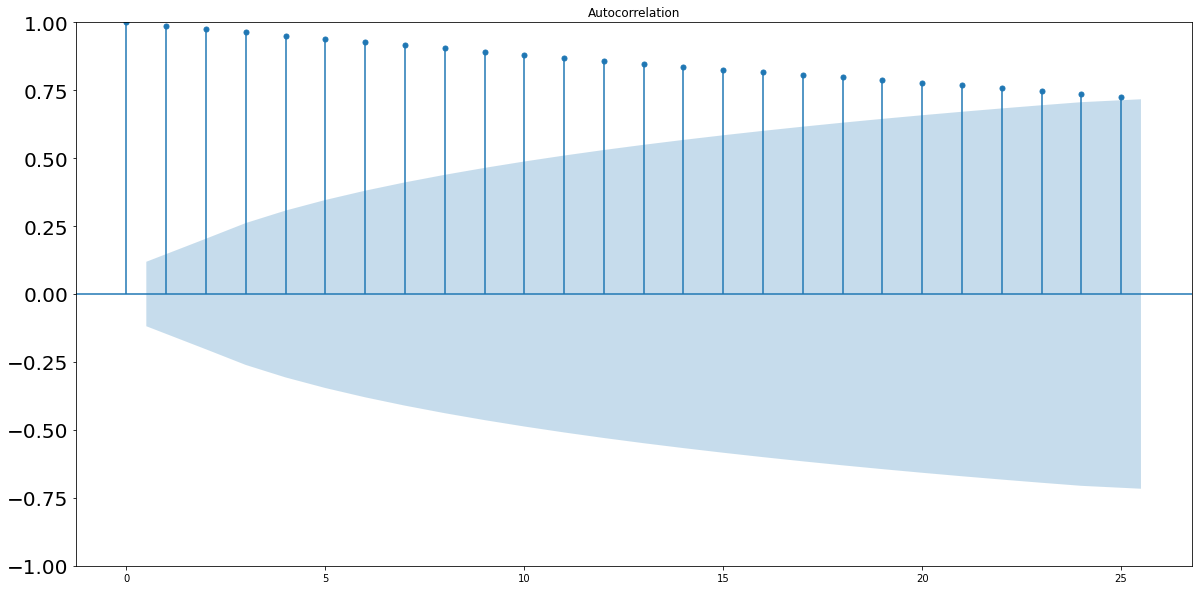

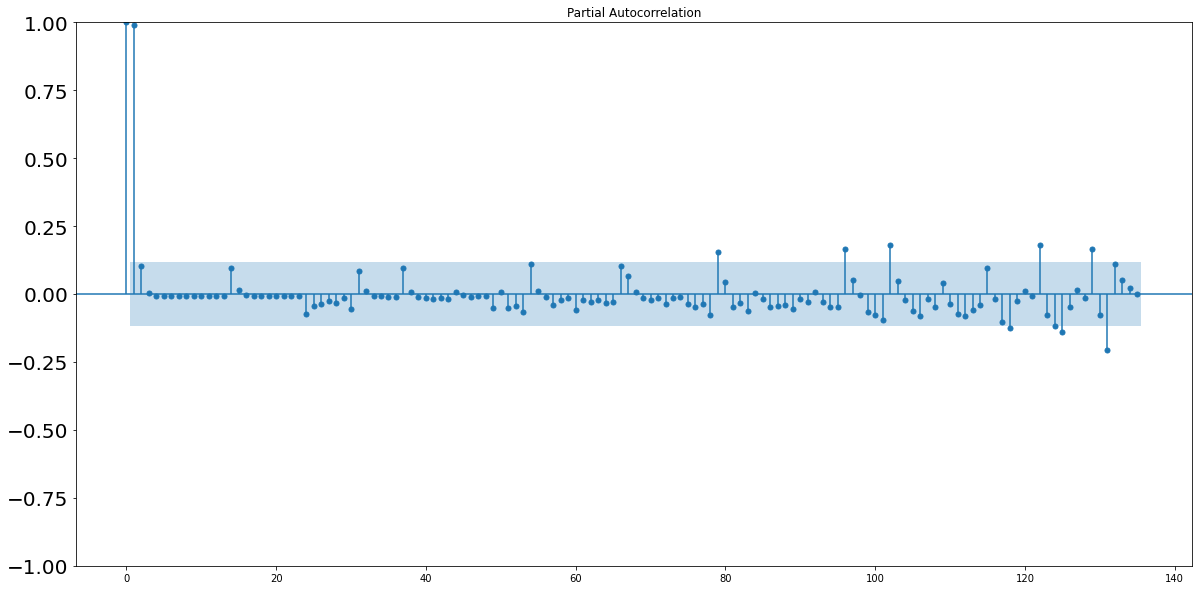

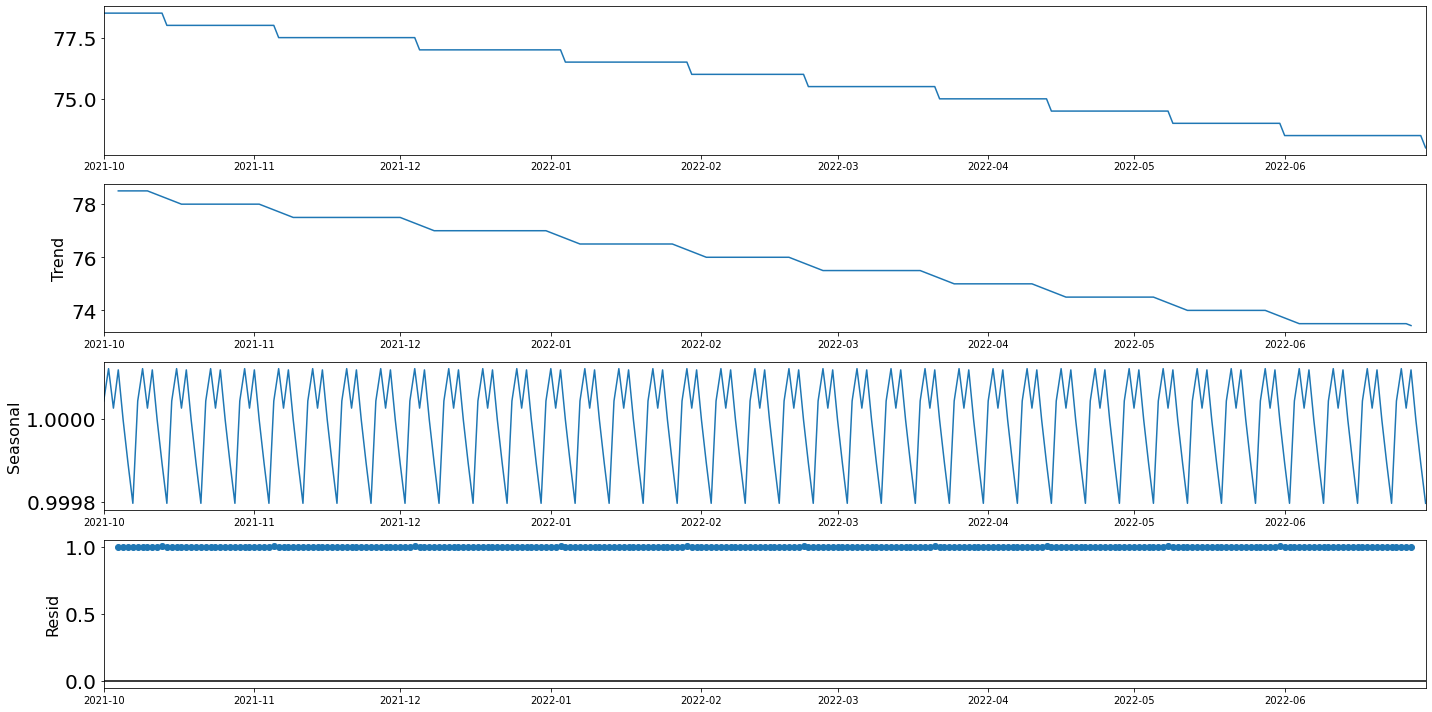

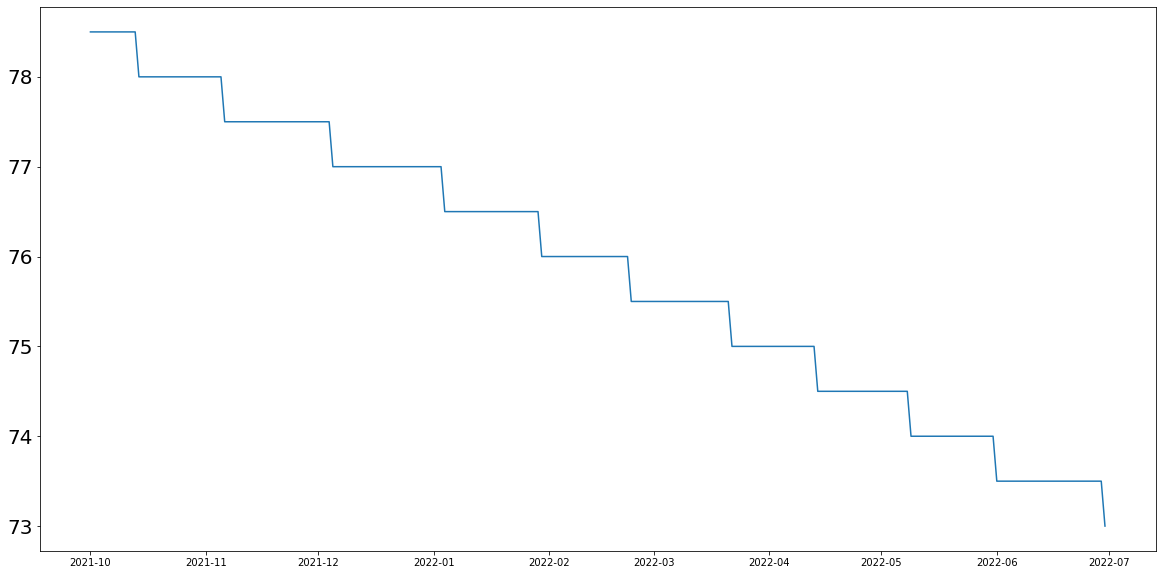

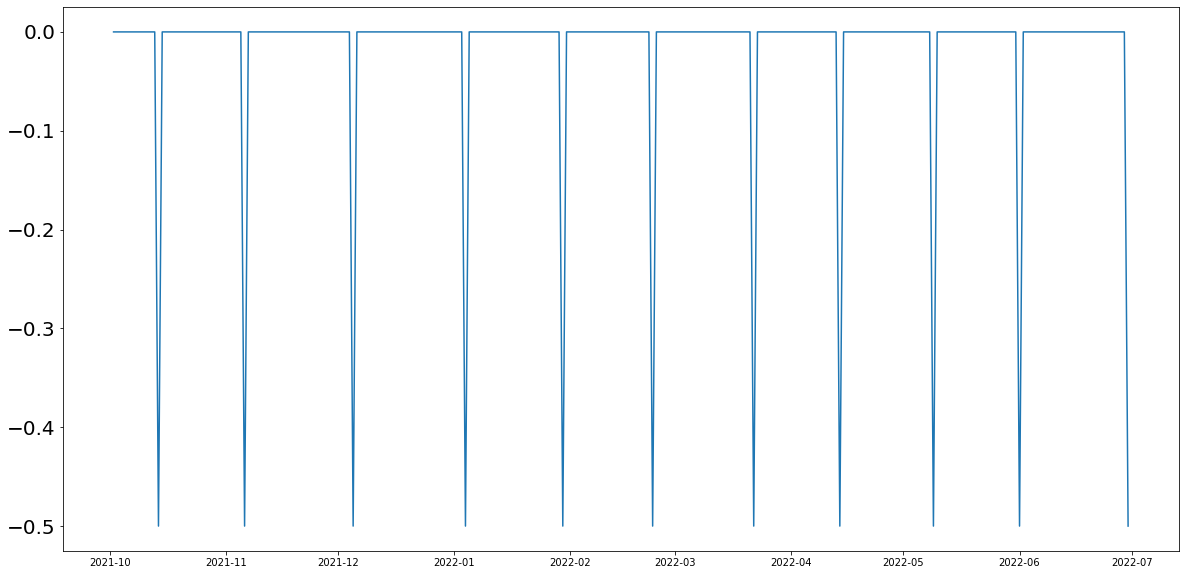

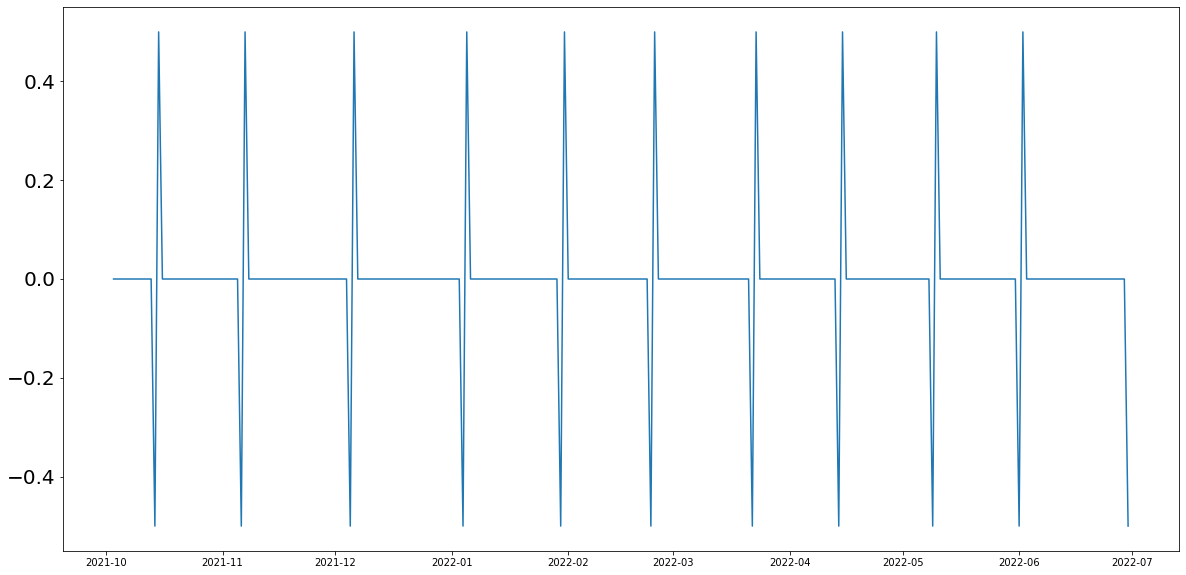

In [49]:
# 여러 차수 출력

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

train_idx = (df.index >= start_day) & (df.index <= end_day)
train = df.loc[train_idx]

val_idx = (df.index >= "2022-03-01") & (df.index <= "2022-03-22")
validation = df.loc[val_idx]

plot_acf(train)
plot_pacf(train, lags=len(train)//2-1)

plt.show()

seasonal_decompose(train, model = 'multiplicative').plot()
plt.show()

plt.plot(train.index,train["SOH"])
plt.show()

diff_1 = train["SOH"].diff().dropna()
plt.plot(diff_1)

plt.show()

diff_2 = diff_1.diff().dropna()
plt.plot(diff_2)

plt.show()


In [210]:
# 직접 ARIMA, SARIMAX의 order를 설정하여 결과 출력

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import statsmodels.api as sm

# best : order = (1,1,1), seasonal_order = (3,1,2,6)
# best : order = (1,1,1), seasonal_order = (2,1,2,6) / AIC=-25.379
# second : order = (1,2,1), seasonal_order = (4,1,2,3)
# third : order = (2,1,1), seasonal_order = (4,1,2,3)

model = SARIMAX(train["SOH"], order = (1,1,1), seasonal_order = (2,1,1,6))

#model = ARIMA(train, order = (1,2,0), enforce_stationarity = False)
model = model.fit()
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                               SOH   No. Observations:                  273
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 6)   Log Likelihood                 236.772
Date:                           Wed, 20 Jul 2022   AIC                           -461.544
Time:                                   14:48:14   BIC                           -440.043
Sample:                               10-01-2021   HQIC                          -452.906
                                    - 06-30-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7905      0.099      8.002      0.000       0.597       0.984
ma.L1         -0.9860      0.058    -16.909

c:\users\juhyeong\desktop\rack_analysis\.venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [230]:
# Auto Arima를 사용하여 자동으로 order 찾아줌

import pmdarima as pm

model = pm.auto_arima(y = train["SOH"],
                      d = 1,
                      start_p = 0, max_p = 5, 
                      start_q = 0, max_q = 5, 
                      start_d = 0, max_d = 5,
                      start_P = 0, max_P = 5,
                      start_Q = 0, max_Q = 5,
                      start_D = 0, max_D = 5,
                      D = 1,
                      m = 12,
                      seasonal = True, stepwise = False,
                      trace=True
                      )

print(model.summary())

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-274.790, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=inf, Time=1.49 sec
 ARIMA(0,1,0)(0,1,4)[12]             : AIC=-422.915, Time=3.81 sec
 ARIMA(0,1,0)(0,1,5)[12]             : AIC=inf, Time=18.60 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-362.133, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=-415.283, Time=0.33 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=1.74 sec
 ARIMA(0,1,0)(1,1,4)[12]             : AIC=-424.622, Time=4.75 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-382.359, Time=0.17 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.45 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=inf, Time=3.19 sec
 ARIMA(0,1,0)(3,1,0)[12]             : 

Total fit time: 153.853 seconds
                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  273
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                 227.114
Date:                                 Wed, 20 Jul 2022   AIC                           -444.227
Time:                                         15:05:09   BIC                           -426.424
Sample:                                              0   HQIC                          -437.070
                                                 - 273                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7832      0.075     10.48

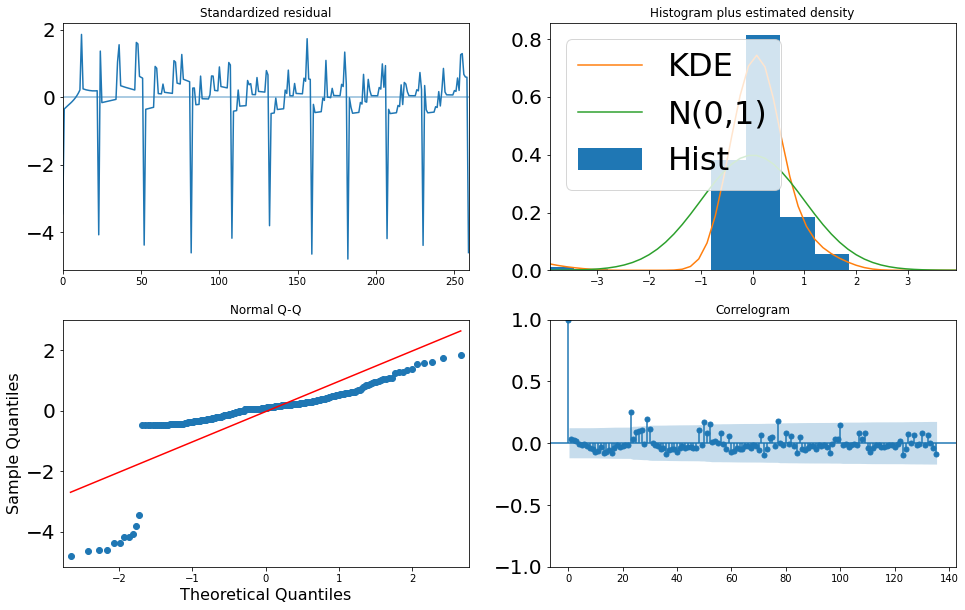

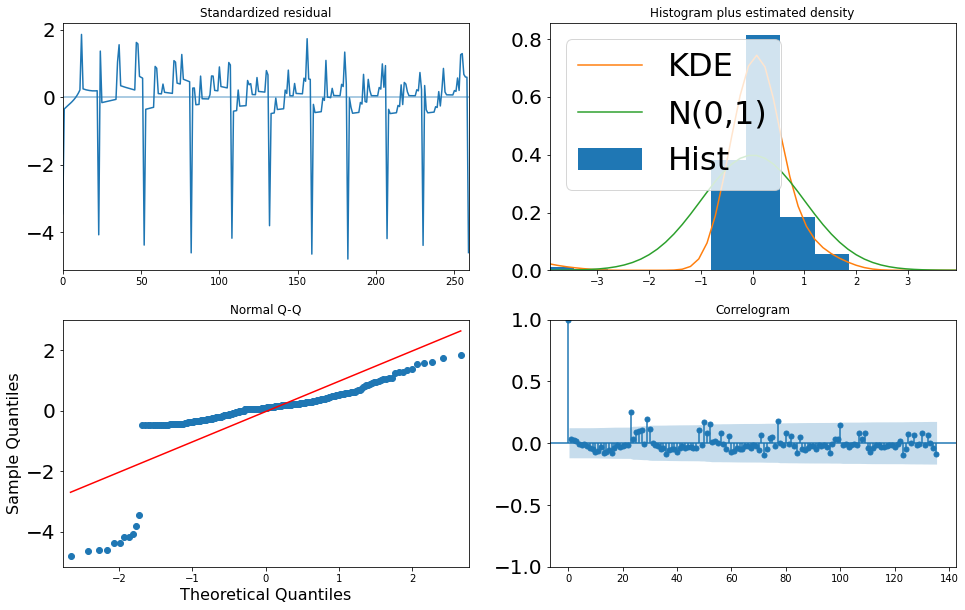

In [231]:
model.plot_diagnostics(figsize=(16,10), lags=len(train)//2-1)

In [232]:
# forecasting으로 결과를 내는 부분

fore_start_day = "2022-07-01" # forecasting 시작 날짜
fore_end_day = "2036-01-01"   # forecasting 종료 날짜

pred_index = pd.date_range(start=fore_start_day, end=fore_end_day,freq='1D')

pred, confint = model.predict(n_periods = len(pred_index), return_conf_int=True)

cf= pd.DataFrame(confint) # confint = ARIMA 예측 값의 오차

(0.0, 100.0)

<Figure size 1152x1152 with 0 Axes>

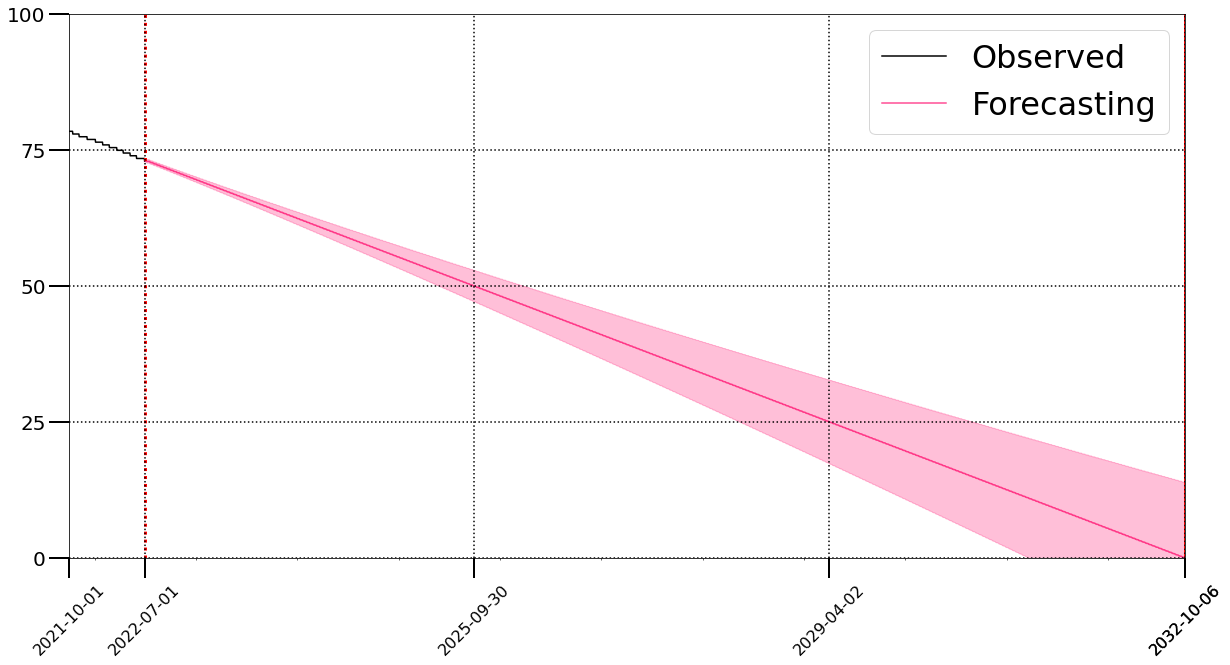

In [233]:
import matplotlib.dates as mdates
from datetime import datetime

plt.figure(figsize=(16,16))
plt.rcParams['figure.figsize'] = [20, 10]
plt.rc('axes', titlesize=12, labelsize=16)
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=32)  # 범례 폰트 크기

def vhline_to_point(pm,v):
    for pidx, pv in zip(pm.index,pm.values):
        if pv <= v:
            ax.axvline(x=pidx, color='black', linestyle=':', ymin =0, ymax=1)
            break
    
    x = pidx
    ax.axhline(y=y, color='black', linestyle=':', xmin=0, xmax=1)
    return x

pred_series = pd.Series(pred,index=pred_index)

ax = train.plot(label='Observed', color="black", legend=True)

ax.plot(pred_series,label='Forecasting', alpha=0.7, color="#ff0066")

ax.fill_between(pred_series.index,
                cf[0],
                cf[1], color='#ff0066',alpha=0.25)

fs_day = datetime.strptime(fore_start_day, "%Y-%m-%d")
ax.axvline(x=fs_day, color='r', linestyle=':', linewidth=3)

for pidx, pv in zip(pred_series.index,pred_series.values):
    if pv <= 0:
        ax.axvline(x=pidx, color='r', linewidth=3)
        break

yy = [75,50,25,0]
xticks = []

for y in yy:
    t = vhline_to_point(pred_series,y)
    
    year = t.year
    month = str(t.month) if len(str(t.month)) == 2 else f"0{t.month}"
    day = str(t.day) if len(str(t.day)) == 2 else f"0{t.day}"
    
    xticks.append(f"{year}-{month}-{day}")

#ax.set_xticks([start_day,end_day,pidx, pred_end_day] + xticks, minor = False)
ax.set_xticks([start_day,pidx, pred_end_day] + xticks, minor = False)
ax.set_xticklabels([start_day,f"{pidx.year}-{pidx.month}-{pidx.day}", pred_end_day] + xticks, rotation = 45, fontsize = 16)

ax.set_yticks([100,75,50,25,0])

ax.tick_params(length=20, width=2)
ax.legend(["Observed", "Forecasting"])

plot_start_day, plot_end_day = datetime.strptime(start_day, "%Y-%m-%d"), pidx

ax.set_xlim([plot_start_day,plot_end_day])
ax.set_ylim([0,100])

# 대략 2033년 8월 28일쯤에 0%로 변함

In [248]:
# 결과 저장
pd.DataFrame(pred, index=pred_index, columns=["forecasting_SOL"]).to_csv("sarima_sol_fore_result.csv")
cf.set_index(pred_index, inplace=False).to_csv("sarima_sol_confint_result.csv")